In [3]:
import torch
from torchvision.models import VisionTransformer
import torch.nn as nn
import pickle
import os
import numpy as np
import pandas as pd

In [11]:
class BinaryViT(nn.Module):
    def __init__(self):
        super(BinaryViT, self).__init__()
        self.vit = VisionTransformer(
                    image_size=224,    # Input image size
                    patch_size=16,     # Patch size
                    hidden_dim=768,          # Embedding dimension
                    num_layers=12,         # Number of transformer layers
                    num_heads=12,         # Number of attention heads
                    mlp_dim=3072,     # Feedforward MLP dimension
                    dropout=0.1,      # Dropout probability
                    num_classes=1  # Output classes
                )
    def forward(self, x):
        x = self.vit(x)
        return x

class CNNAttempt(nn.Module):
    def __init__(self):
        super(CNNAttempt, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, 1)  # Binary output
        self.act= nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(self.act(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(self.act(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
weights = torch.load("models_aidectect/cnn_trained_on_cropped.pth", map_location="cpu")
model = CNNAttempt()
model.load_state_dict(weights)
#compute params
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters in the model: ", total_params)
model.eval()

Total parameters in the model:  102781057


CNNAttempt(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [13]:
from PIL import Image
from torchvision.transforms import v2
# load validation/0/xp.jpeg image
def predict(model: BinaryViT, image: Image.Image) -> bool:
    transform = v2.Compose([
        v2.Resize((224, 224)),  # Resize to the input size of the model
        v2.ToTensor(),          # Convert to tensor
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(image)
        #pass through a sigmoid
        output = torch.sigmoid(output)
    return output.item()


0.47450628876686096


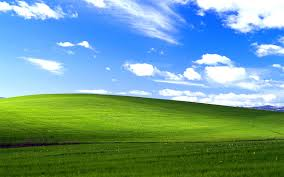

In [14]:
img = Image.open("validation/0/xp.jpeg")
print(predict(model, img))
img

0.864038348197937


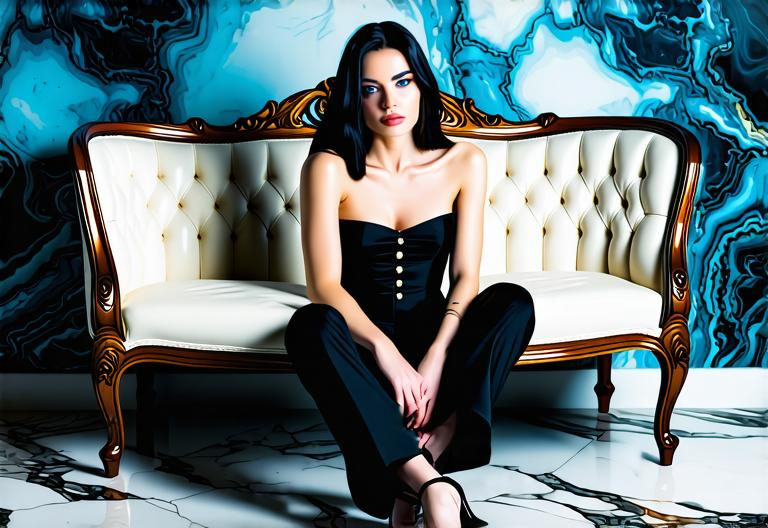

In [15]:
img = Image.open("/home/dan/.cache/kagglehub/datasets/shreyasraghav/shutterstock-dataset-for-ai-vs-human-gen-image/versions/2/test_data/006cb1fd07c6462a9795df252c6c2f53.jpg")
print(predict(model, img))
img

0.1303793489933014


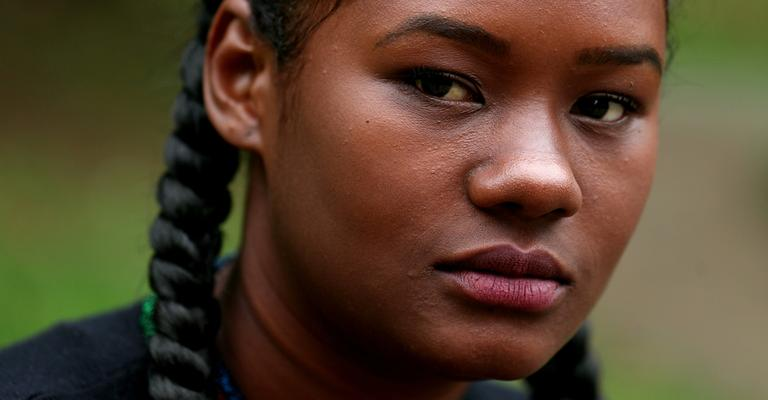

In [16]:
img = Image.open("/home/dan/.cache/kagglehub/datasets/shreyasraghav/shutterstock-dataset-for-ai-vs-human-gen-image/versions/2/test_data/ffaf21d6f59740c1a2c5c5a1e2eb13d8.jpg")
print(predict(model, img))
img

In [17]:
import ipywidgets as widgets
folder_path = 'validation/1'
image_files = [f for f in os.listdir(folder_path)]
images = [(Image.open(os.path.join(folder_path, f)), True) for f in image_files]
# folder_path = 'validation/0'
# image_files = [f for f in os.listdir(folder_path)]
# images += [(Image.open(os.path.join(folder_path, f)), False) for f in image_files]

slider = widgets.IntSlider(min=0, max=len(images)-1, step=1, value=0)
def update_image(change):
    img = images[change][0]
    prediction = predict(model, img)
    print(f'Prediction: {prediction} \nIs AI: {images[change][1]}')
    display(img)
widgets.interact(update_image, change=slider)


interactive(children=(IntSlider(value=0, description='change', max=13), Output()), _dom_classes=('widget-inter…

<function __main__.update_image(change)>